## Preface and TOC
This script is meant to classify a given polygone-based file containing footprint data of buildings of Hue City, Vietnam. 
The buildings will be classified to one of the following classes:

- Shophouse `sh`
- Single Family `sf`
- Multi Family `mf`
- Uninhabited Large `ul`
- Uninhabited Small `us`

**Table of content**


1. [Head: In the first section all the variables and functions are defined and the input-data will be preprocessed](#head)

    1.1. [Declaration of variables](#vars)
    
    1.2. [Declaration of functions](#functions)

2. [Main Script](#main)

    2.1 [First step: In the main-section the basic parameters are derived from the footprints](#first)
    
    2.1.1. [Addition of training classes: The given training classes are being added to the previously created dataset for external use in Orange's DT-classifier](#add_train)
    
    2.1.2. [First classification: The first three classes get classified](#class1)

    2.2. [Second step: Derivation of the second step's parameters](#second)

    2.2.1. [Second classification: The until here unclassified polygons are being classified](#class2)

    2.2.2. [Finalization: The new parameters as well as the new classes are being merged to the dataset, created in 2.1.2. and written to HD](#final)

3. [Accuracy assessment: Confusion matrices for accuracy measurements](#acc)

4. [Statistics: Statistical evaluations](#statistics)

    4.1. [Feature counts: Simple display of the counts of single classes](#feature_counts)

    4.2. [Ward related statistics: Counting building types in wards](#wards)

    4.3. [Boxplots and histograms: Generation of boxplots and histograms for each parameter, devided by classes](#boxplots)

    4.4. [Residential Housings: Statistical evaluation of housings per floor area](#resi)

    4.5. [Calculation of parameters' mean values and standard deviation per class](#means)

---



<a name="head"></a>
# Head

In [1]:
import platform
if platform.system() == 'Windows':
    !conda create -y -n Hue_classification
    !conda activate Hue_classification

###
# NOTE: momepy works better when installed from conda-forge
# installation via conda in Google Colab requires condacolab installed
# -> condacolab by Jaime Rodríguez-Guerra: https://github.com/jaimergp/condacolab
# Not neccessary in Jupyter Notebook
# !pip install -q condacolab
# import condacolab
# condacolab.install()
###

!conda install momepy -y #-n Hue_classification
!conda install plotnine -y #-n Hue_classification
!conda install dask -y #-n Hue_classification
# %reset clears all variables

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [2]:
import momepy as mp
import geopandas as gpd
import pandas as pd
import time 
import numpy as np
from plotnine import *
import sklearn.metrics as metrics
import warnings
import os
from tqdm import tqdm
from collections import Counter

<a name="vars"></a>
## Declaration of variables

In [3]:
###### Variables ######

update_mode = False  # if True, outfile_first will be loaded instead of infile
precision = 5  # precision of calculated values
do_tessellation = True  # calculate time demanding tessellation
do_enclosed_tess = True  # enclosed tessellation makes only sense if the given data is of higher quality
do_preprocessing = True  # time demandeng MP-preprocessing
minsize = 2  # buildings smaller than this will be cut out by mp.preprocess()
gpd.options.use_pygeos = True  # using PYGEOS speeds up certain operations
start_time = time.time()  # starting time for time measurement
os.chdir('/media/user/Daten/BA_workdir/Jupyter_workdir/')  # sets the working directory
# if there is no subdirectory named 'Output' create one
if not os.path.exists('./Output'):
    os.mkdir('./Output')
    os.mkdir('./Output/Daten')
    os.mkdir('./Output/Klassifikation')
    os.mkdir('./Output/Statistik')
    
# data input
infile = './Input/Hue_buildings_WGS84.geojson'
roads_in = './Input/Hue_osm_roads_free.shp'
water_in = './Input/Hue_osm_water_free.shp'
training_classes_in = "./Input/Hue_training_classes_no_params.csv"
landuse_in = None  # './Input/Hue_gis_osm_landuse_a_free.shp'
townhall_in = None  # './Input/Hue_town_hall.shp'
max_density_spot_in = None  # './Input/Daten/Hue_max_density_spot.shp'
k_dense_in = None  # './Input/Hue_kernal_density_1km.csv'
reference_classes = './Input/Hue_reference_classes_preprocessed.csv'

# data output
infile_preprocessed = './Input/Hue_buildings_UTM48N_preprocessed.shp' 
outfile_first = './Output/Daten/Hue_buildings_UTM48N_preprocessed_first_no_classes.shp'
data_w_training_classes_out = "./Output/Daten/Hue_buildings_UTM48N_preprocessed_edited_w_training_classes.shp"
outfile_classified = './Output/Daten/Hue_buildings_UTM48N_classified_full.shp'
tess_out = './Output/Daten/Hue_tessellation.shp'
tess_encl_out = './Output/Daten/Hue_tessellation_enclosed.shp'
outfile_blocks = './Output/Daten/Hue_blocks.shp'


<a name="functions"></a>
## Declaration of functions

In [4]:
###### Functions ######

def reproject(shp):
    """
    Converts shp to metric CRS if neccesary    
    """
    if shp.crs != 'EPSG:32648':
        print("Reprojecting to EPSG 32648")
        shp = shp.to_crs("EPSG:32648")
    return shp


def msize(gdf, radius, ignore_current=True):
    """
    Calculates the mean footprint area of surrounding buildings within a given 
    range, excluding the current buildings area.
    Adds 1 new column to the given GeoDataFrame.
    """

    for i, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):
        idx = data.sindex.query(row.geometry.buffer(radius), predicate='contains')
        if ignore_current:
            idx = np.delete(idx, np.where(idx == i))
        if len(idx) == 0:
            gdf.loc[i, 'msize_' + str(radius)] = 0
            continue
        else:
            gdf.loc[i, 'msize_' + str(radius)] = sum(gdf.iloc[idx].area) / len(idx)
    return gdf


def mabr(gdf):
    """
    Calculates area, width and length for each opjects 
    minimum area bounding rectangle in the given gdf.
    Adds 3 new columns to the given GeoDataFrame.
    """
    for i, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):
        mabr = row.geometry.minimum_rotated_rectangle
        gdf.loc[i, 'area_mabr'] = mabr.area
        gdf.loc[i, 'width'] = mabr.minimum_clearance
        gdf.loc[i, 'length'] = (mabr.length - (2 * mabr.minimum_clearance)) / 2

    return gdf


def mean_orientation(gdf, radius, ignore_current=True):
    """
    Calculates building's orientations. Then, calculates mean deviation
    of each building from surrounding buildings within the given range.
    Adds 3 new columns to the given GeoDataFrame.
    """
    if 'orient' not in gdf:
        print("\n")
        gdf['orient'] = mp.Orientation(gdf, verbose=True).series

    for i, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):
        idx_orient = gdf.sindex.query(row.geometry.buffer(radius),
                                      predicate='intersects')
        if ignore_current:
            idx_orient = np.delete(idx_orient,
                                   np.where(idx_orient == i))
        sum_orient = sum(gdf.iloc[idx_orient].orient)
        try:
            gdf.loc[i, 'orient_' + str(radius)] = sum_orient / len(idx_orient)
        except ZeroDivisionError:
            gdf.loc[i, 'orient_' + str(radius)] = row.orient
    gdf['orient_dev'] = abs(gdf.orient - gdf['orient_'+ str(radius)])

    return gdf


print("Importing data...")
if update_mode:
    data = reproject(gpd.read_file(outfile_first))
    data.FID = data.FID.astype(np.int64)
else:
    data = reproject(gpd.read_file(infile))

####### Preprocessings and preparations ######

if 'FID' not in data:
    data['FID'] = mp.unique_id(data)

if do_preprocessing and not update_mode:
    print("Preprocessing...")
    data = mp.preprocess(data, size=minsize)
    defect = mp.CheckTessellationInput(data)
    data = data.drop(defect.split.append(defect.overlap.append(defect.collapse)).index)
    n_drop = data.shape[0] - data.FID.drop_duplicates().shape[0]
    data.to_file(infile_preprocessed, driver='GeoJSON', encoding='utf-8')
    print("{} features with erroneus geometry were dropped from the GeoDataFrame.".format(
        len(defect.split.append(defect.overlap.append(defect.collapse)))))
    print("{} duplicated features were dropped.".format(data.shape[0] - data.FID.drop_duplicates().shape[0]))


Importing data...
Reprojecting to EPSG 32648
Preprocessing...
Loop 1 out of 2.


Changing geometry: 100%|██████████| 262/262 [00:22<00:00, 11.42it/s]


Loop 2 out of 2.


Changing geometry: 100%|██████████| 22/22 [00:02<00:00, 10.31it/s]


Collapsed features  : 0
Split features      : 18
Overlapping features: 49
67 features with erroneus geometry were dropped from the GeoDataFrame.
0 duplicated features were dropped.


<a name="main"></a>
# Main script

---



<a name="first"></a>
## First step: generation of the base parameters

In [5]:
###### Main script ######
print("Calculating areas...")
data['area'] = data.geometry.area

print("Calculating corners...")
data['corners'] = mp.Corners(data, verbose=False).series

print("Calculating perimeters...")
data['perimeter'] = mp.Perimeter(data).series

print("Calculating rectangularity values...")
data['rect'] = mp.Rectangularity(data, areas='area').series

print("Calculating perimeter per area...")
data['shp_ratio'] = data.area / data.perimeter

print("Calculating shape index...")
data['shp_index'] = data.perimeter / (2 * np.sqrt(np.pi * data.area))

print("Calculating length, width and area of MABRs...")
data = mabr(data)

print("Calculating elongations...")
data['elongation'] = data.width / data.length

print("Calculating orientations...")
data = mean_orientation(data, 100)

print("Calculating shared walls...")
data['shrd_walls'] = abs(np.round(mp.SharedWalls(data).series, 0))

print("Evaluating proximity...")
for i, row in tqdm(data.iterrows(),
                   total=data.shape[0]):
    if row['shrd_walls'] == 0:
        data.loc[i, 'proximity'] = 'detached'
    elif row['shrd_walls'] <= int(row['length']):
        data.loc[i, 'proximity'] = 'semi-detached'
    else:
        data.loc[i, 'proximity'] = 'attached'

print("Counting buildings within 50, 100, 200 m and 1 ha range...")
for i, row in tqdm(data.iterrows(),
                   total=data.shape[0]):
    data.loc[i, 'n_in_50m'] = len(data.sindex.query(row.geometry.buffer(50),
                                                    predicate='intersects'))

    data.loc[i, 'n_in_100m'] = len(data.sindex.query(row.geometry.buffer(100),
                                                     predicate='intersects'))

    data.loc[i, 'n_in_200m'] = len(data.sindex.query(row.geometry.buffer(200),
                                                     predicate='intersects'))

    data.loc[i, 'n_in_ha'] = len(data.sindex.query(row.geometry.buffer(
        np.sqrt(10000 / (2 * np.pi))),
        predicate='intersects'))

# TODO: Raus!
# Add landuse information based on OSM data
if landuse_in is not None:
    print("Adding OSM-landuse information...")
    landuse = reproject(gpd.read_file(landuse_in))
    index_within = []
    data['landuse'] = 'unknown'
    for i in tqdm(range(len(landuse))):
        index_within = data.geometry.within(landuse.geometry.iloc[i])
        index_within = index_within[index_within]
        for j in range(len(index_within)):
            data.loc[index_within.index[j], 'landuse'] = landuse.loc[i, 'fclass']

# TODO: Raus!
# Add kernal density information to each feature
# if k_dense_in is not None:
#     print("Adding kernal density information...")
#     k_dense = gpd.read_file(k_dense_in)
#     k_dense.k_dens_1km = k_dense.k_dens_1km.astype(float)
#     k_dense.FID = k_dense.FID.astype(np.int64)
#     data = data.merge(k_dense[['FID', 'k_dens_1km']], on='FID')

# Calculate distances to roads
if roads_in is not None:
    print("Preparing roads...")
    roads = reproject(gpd.read_file(roads_in))
    roads = mp.extend_lines(roads, 0.25)
    roads = mp.close_gaps(roads, 0.25)
    roads = mp.remove_false_nodes(roads)
    roads_union = roads.unary_union  # unifies all roads
    print("Calculating distances to roads...")
    for i, row in tqdm(data.iterrows(),
                       total=data.shape[0]):
        data.loc[i, 'to_roads'] = row.geometry.boundary.distance(roads_union)

# Roads in range
print("Counting roads within 100 and 250 m range...")
for i, row in tqdm(data.iterrows(),
                   total=data.shape[0]):
    data.loc[i, 'roads_100'] = len(roads.geometry.sindex.query(
        row.geometry.buffer(100), predicate='intersects'))
    data.loc[i, 'roads_250'] = len(roads.geometry.sindex.query(
        row.geometry.buffer(250), predicate='intersects'))

# TODO: Raus!
# Caculate distances to to town hall
if townhall_in is not None:
    print("Calculating distances to town hall...")
    townhall = reproject(gpd.read_file(townhall_in))
    data['to_hall'] = data.geometry.distance(townhall.loc[0, 'geometry'], align=False)

# TODO: Raus!
if max_density_spot_in is not None:
    print("Calculating distances to highest density spot...")
    max_density_spot = reproject(gpd.read_file(max_density_spot_in))
    data['to_centre'] = data.geometry.distance(max_density_spot.loc[0, 'geometry'], align=False)

# Mean size of buildings in a given range 
# this is very time demanding
print("Calculating mean area of buildings within 50 m and 100 m range")
data = msize(data, 50)
data = msize(data, 100)

if do_tessellation:
    print("Calculating tessellation layer...")
    if not do_enclosed_tess:
        limit = mp.buffered_limit(data)
        tessellation = mp.Tessellation(data,
                                       unique_id='FID',
                                       limit=limit,
                                       verbose=True
                                       ).tessellation
        tessellation['tess_area'] = mp.Area(tessellation).series
        print("Writing tessellation results to file...")
        tessellation.to_file(tess_out)

    elif do_enclosed_tess and roads_in is not None and water_in is not None:
        # if waters an roads are present do enclosed tessellation:
        # enclosed tessellation needs roads and water information for the 
        # creation of boundaries. May cause problems when intersecting with buildings.
        
        roads = reproject(gpd.read_file(roads_in))
        roads = mp.extend_lines(roads, 0.25)
        roads = mp.close_gaps(roads, 0.25)
        roads = mp.remove_false_nodes(roads)
        water = reproject(gpd.read_file(water_in))
        enclosures = mp.enclosures(roads, limit=gpd.GeoSeries(
            [data.unary_union.convex_hull.buffer(10)]),
                                   additional_barriers=[water.boundary])
        tessellation = mp.Tessellation(data,
                                       unique_id='FID',
                                       enclosures=enclosures,
                                       verbose=True
                                       ).tessellation
        tessellation['tess_area'] = tessellation.area
        print("Writing tessellation results to file...")
        tessellation.to_file(tess_encl_out)

    print("Adding tessellation related information: tess_area and CAR...")
    # in rare cases where only one building is situated within a bounded area
    # this building won't be envolved in the tessellation. Thus the following 
    # statement hands the area of the untessellated cell to the building
    
    FID_not_tessellated = list(
        data[data.FID.isin(tessellation[tessellation.FID.isna() == False].FID
        ) == False].FID)
    if len(FID_not_tessellated) > 0:
        for i in tqdm(FID_not_tessellated,
                      desc='Adding "tess_area" for single inbound buildings'):
            tessellation.loc[
                tessellation.sindex.query(
                    data.loc[data[data.FID == i].index[0]].geometry,
                    predicate='within')[0], 'FID'] = i
    for i, row in tqdm(data.iterrows(), total=data.shape[0],
                       desc='Adding "tess_area"'):
        data.loc[i, 'tess_area'] = tessellation.loc[tessellation.FID == row.FID, 
                                                    'tess_area'].values
    data['CAR'] = data.area / data.tess_area

print("Generating blocks...")
blocks = mp.Blocks(tessellation=tessellation,
                   edges=roads,
                   buildings=data, 
                   id_name = 'bID',
                   unique_id = 'FID')

blocks.blocks.to_file(outfile_blocks, encoding='utf-8')

for i, row in tqdm(data.iterrows(), total=data.shape[0], desc='Adding "bID" to dataset'):
    data.loc[i, 'bID'] = blocks.blocks.sindex.query(data.loc[i].geometry,
                                                    predicate='within')[0]

print("Calculating building's mean sizes and built up ratio within blocks...")
data['b_msize'] = data.area
data['b_builtup'] = 0
data['b_medsize'] = data.area
bID_set = list(set(data.bID))
for i in range(len(bID_set)):
    buildings_in_block = data.loc[data.bID == bID_set[i]]
    data.loc[data.FID.isin(buildings_in_block.FID), 
             'b_msize'] = buildings_in_block.area.sum() / len(buildings_in_block)
    data.loc[data.FID.isin(buildings_in_block.FID), 
             'b_medsize'] = buildings_in_block.area.median()
    data.loc[data.FID.isin(buildings_in_block.FID), 
             'b_builtup'] = buildings_in_block.area.sum() / row.geometry.area

# rounds all numerical values to the given precision
data = np.round(data, precision)

print('Writing output file...')
data.to_file(outfile_first, encoding='utf-8')
print("\nProcess finished. It took {time} minutes.\n"
      "Output written to '{fname}.".format(time=round((time.time() - start_time) / 60), fname=outfile_first))


Calculating areas...
Calculating corners...


/home/user/miniconda3/lib/python3.9/site-packages/momepy/shape.py:795: RuntimeWarning: invalid value encountered in arccos
/home/user/miniconda3/lib/python3.9/site-packages/momepy/shape.py:794: RuntimeWarning: invalid value encountered in double_scalars


Calculating perimeters...
Calculating rectangularity values...


  0%|          | 0/108749 [00:00<?, ?it/s]

Calculating perimeter per area...
Calculating shape index...
Calculating length, width and area of MABRs...


  0%|          | 205/108749 [00:00<00:52, 2049.43it/s]

Calculating elongations...
Calculating orientations...




100%|██████████| 108749/108749 [25:36<00:00, 70.78it/s]


Calculating shared walls...


  0%|          | 0/108749 [00:00<?, ?it/s]

Evaluating proximity...


  0%|          | 0/108749 [00:00<?, ?it/s]

Counting buildings within 50, 100, 200 m and 1 ha range...


100%|██████████| 108749/108749 [11:11<00:00, 161.99it/s]


Preparing roads...
Reprojecting to EPSG 32648


  0%|          | 0/108749 [00:00<?, ?it/s]

Calculating distances to roads...


  0%|          | 0/108749 [00:00<?, ?it/s]

Counting roads within 100 and 250 m range...


  0%|          | 0/108749 [00:00<?, ?it/s]

Calculating mean area of buildings within 50 m and 100 m range


100%|██████████| 108749/108749 [27:52<00:00, 65.04it/s]


Calculating tessellation layer...
Reprojecting to EPSG 32648
Reprojecting to EPSG 32648
Writing tessellation results to file...


Adding "tess_area" for single inbound buildings:   0%|          | 0/55 [00:00<?, ?it/s]

Adding tessellation related information: tess_area and CAR...


Adding "tess_area": 100%|██████████| 108749/108749 [02:55<00:00, 619.44it/s]


Generating blocks...


Adding "bID" to dataset: 100%|██████████| 108749/108749 [02:39<00:00, 681.05it/s]


Calculating building's mean sizes and built up ratio within blocks...
Writing output file...

Process finished. It took 149 minutes.
Output written to './Output/Daten/Hue_buildings_UTM48N_preprocessed_first_no_classes.shp.


<a name="add_train"></a>
### Addition of taining classes
Here, the training classes are being applied to the `data` GeoDataFrame. The output copy should only contain features with defined class in the `class_name` attribute. The `FID` attribute serves as identifier. The result is meant to be used during the training of the classifier. 

Inputs:

`Hue_training_classes_no_params.csv` file containing the training classes

`outfile_first` should be the same as `data` but is read from the hd just in case `data` doesn't exist

Outputs: 

`Hue_buildings_UTM48N_preprocessed_edited_w_training_classes.shp`

`Hue_buildings_UTM48N_preprocessed_edited_w_training_classes.shp.csv`

`Hue_training_classes_w_params.csv`

In [6]:
###### Add classes ######

classes = gpd.read_file(training_classes_in)
classes.FID = classes.FID.astype(np.int64)
data_w_training_classes = gpd.read_file(outfile_first)
data_w_training_classes.FID = data_w_training_classes.FID.astype(np.int64)
for i, row in classes.iterrows():
    data_w_training_classes.loc[data_w_training_classes.FID == row.FID,
                                'class_name'] = row['class_name']
    # data_w_training_classes.loc[data_w_training_classes.FID == row.FID, 'class_info'] = row['class_info']

# write only features with set class_name as csv
data_w_training_classes[data_w_training_classes.class_name.isnull() == False].to_csv(
    "./Output/Klassifikation/Hue_1st_step_training_classes_w_params.csv")

# write the whole data table as shapefile and csv
data_w_training_classes.to_file(data_w_training_classes_out, encoding='utf-8')
data_w_training_classes.loc[data_w_training_classes.class_name.isnull() == False, 'class_name']
data_w_training_classes.to_csv(data_w_training_classes_out+".csv")

<a name="class1"></a>
### First classification

The new dataset `data_w_classes` is created here. It contains all the information of `data` (parameters). 
In this first step the classes `us`, `sh` and `sf` are beeing added. The thresholds where calculated with help of the Orange decision tree classification.

Input:

`outfile_first`-defined file containing all attributes


In [7]:
data_w_classes = gpd.read_file(outfile_first)
data_w_classes.FID = data_w_classes.FID.astype(np.int64)

data_w_classes.loc[data_w_classes.area <= 30, 'class_name'] = 'us'

data_w_classes.loc[ (data_w_classes.class_name != 'us') &
                    (
                        (data_w_classes.area > 30) &
                        (data_w_classes.area_mabr <= 141.80) &
                        (data_w_classes.elongation <= 0.17) &
                        (data_w_classes.b_msize <= 120.15)
                    ),
                    'class_name'] = 'sh'

data_w_classes.loc[ (data_w_classes.class_name != 'us') &
                    (data_w_classes.class_name != 'sh') &
                    (
                        (data_w_classes.area > 30) &
                        (data_w_classes.area_mabr <= 141.80) &
                        (data_w_classes.elongation > 0.17)
                    ),
                    'class_name'] = 'sf'

data_w_classes.loc[data_w_classes.class_name.isnull() == True, 'class_name'] = 'mf_ul'


<a name="second"></a>
## Second step: generation of further parameters
After `sh`, `us` and `sf` have been classified, a subset containing only the potential mf and ul classes is generated here. The following will be done:

*   Generate subset `data_mful` 
*   Calculate additional parameters based on `data_w_classes` from the first step
*   Add training class names
*   Save `./Output/Daten/Hue_buildings_UTM48N_preprocessed_classes_2nd_step.csv` containing new subset
*   Save `./Output/Klassifikation/Hue_2nd_step_training_classes_w_params.csv` containing second steps training classes w/ params
*   Save `./Output/Klassifikation/Hue_reference_classes_preprocessed_mful_w_params.csv` containing only `mf` and `ul` reference classes with params

Note: These operations can be done using the index because `data_mful` inherits it from `data_w_classes`. 




In [8]:
data_w_classes_no_us = data_w_classes.copy()
# data_mful = data_w_classes[data_w_classes.class_name.isnull() == True]
data_mful = gpd.GeoDataFrame(data_w_classes[data_w_classes.class_name == 'mf_ul'])
# data_w_classes[(data_w_classes.class_name != 'us') &
#                            (data_w_classes.class_name != 'sf') &
#                            (data_w_classes.class_name != 'sh')]    

# data_mful = mp.preprocess(data_mful, size=20) # unifies touching features
# data_mful = data_mful.drop(columns='class_name', axis=1)

# with or without centroid makes a big difference here
print("Retrieving most common class within 50 m range...")
for i, row in tqdm(data_mful.iterrows(), total=data_mful.shape[0]):
    found_classes = data_w_classes_no_us.iloc[data_w_classes_no_us.sindex.query(
        row.geometry.buffer(50),
        predicate='intersects')
        ].class_name
    # found_classes = found_classes.drop(index=i) # remove subject
    if len(found_classes) > 0:
        data_mful.loc[i, 'class_50'] = Counter(found_classes).most_common(1)[0][0]
    else:
        data_mful.loc[i, 'class_50'] = 'mf_ul'

print("Retrieving nearest building's class...")
for i, row in tqdm(data_mful.iterrows(), total=data_mful.shape[0]):
    # TODO
    with warnings.catch_warnings():  # suppresses overflow warning in the distance process
       warnings.simplefilter(action='ignore', category=Warning) 
       nearest = data_w_classes_no_us.iloc[data_w_classes_no_us.sindex.query(
            row.geometry.buffer(50),
            predicate='intersects')].geometry.distance(row.geometry)
       nearest = nearest.drop(index=i)  # remove current object from lcolab_classesist
    if len(nearest) == 0:
        continue
    # if there are more than one dist = 0 classes 
    # and at least one of them is mf_ul, set mf_ul as nearest
    else: 
        if len(nearest[nearest == 0]) > 1 and 'mf_ul' in data_w_classes_no_us.loc[
                nearest[nearest == 0].index, 'class_name'].values:
            data_mful.loc[i, 'nearest'] = 'mf_ul'
            continue
        nearest = data_w_classes_no_us.loc[nearest[nearest == min(nearest)
                                                   ].index[0], 'class_name']
        if type(nearest) is not str:
            data_mful.loc[i, 'nearest'] = 'mf_ul'
        else: # if nearest 
            data_mful.loc[i, 'nearest'] = nearest

bID_set = list(set(data_w_classes_no_us.bID))
print("Retrieving most common class and share of mf_ul classes within blocks...")
for i in tqdm(bID_set):
    buildings_in_block = data_w_classes_no_us[data_w_classes_no_us.bID == i]
    # index = data_w_classes_no_us.loc[buildings_in_block.index].index
    data_mful.loc[data_mful.FID.isin(buildings_in_block.FID), 'b_class'] = \
        Counter(buildings_in_block.class_name).most_common(1)[0][0]

    b_mful_rat = np.round(
        len(buildings_in_block[buildings_in_block.class_name == 'mf_ul']) / \
        len(data[data.bID == buildings_in_block.iloc[0].bID]), precision)
    data_mful.loc[data_mful.FID.isin(buildings_in_block.FID), 'b_mful_rat'] = b_mful_rat

print("Counting mf and ul classes within 50 m range...")
for i, row in tqdm(data_mful.iterrows(), total=data_mful.shape[0]):
    mful_idx = data_mful.sindex.query(row.geometry.buffer(50), predicate='intersects')
    mful_idx = np.delete(mful_idx, np.where(mful_idx == i))
    data_mful.loc[i, 'mful_50m'] = len(mful_idx)

# write whole dataset containing mf and ul classes without training classes
data_mful.to_csv("./Output/Daten/Hue_buildings_UTM48N_preprocessed_classes_2nd_step.csv")

# write 2nd step's training classes
classes = gpd.read_file(training_classes_in)
classes.FID = classes.FID.astype(np.int64)
data_mful.FID = data_mful.FID.astype(np.int64)
try:
    data_mful_training_w_params = data_mful.drop('class_name', axis=1)
except KeyError:
    pass
data_mful_training_w_params = data_mful_training_w_params.merge(classes[['class_name', 'FID']],
                                                                on='FID')  # ,'class_info'
data_mful_training_w_params.to_csv("./Output/Klassifikation/Hue_2nd_step_training_classes_w_params.csv")

# write new mful-reference classes with params to file
ref = gpd.read_file(reference_classes)
ref.FID = ref.FID.astype(np.int64)
try:
    data_mful_ref = ref.merge(data_mful.drop(columns='class_name', axis=1), on='FID')
except KeyError:
    data_mful_ref = ref.merge(data_mful, on='FID')
data_mful_ref.to_csv('./Output/Klassifikation/Hue_reference_classes_preprocessed_mful_w_params.csv')

  0%|          | 1/5085 [00:00<14:25,  5.87it/s]

Retrieving most common class within 50 m range...


  0%|          | 2/5085 [00:00<04:33, 18.55it/s]

Retrieving nearest building's class...


  0%|          | 3/1102 [00:00<00:41, 26.56it/s]

Retrieving most common class and share of mf_ul classes within blocks...


  0%|          | 23/5085 [00:00<00:22, 229.64it/s]

Counting mf and ul classes within 50 m range...


100%|██████████| 5085/5085 [00:04<00:00, 1235.29it/s]


<a name="class2"></a>
### Second classification
Application of the DT-threhsold-based ruleset to classify `mf` and `ul` classes to the `data_mful` subset.

In [9]:
try:
    data_mful = data_mful.drop(columns='class_name')
except KeyError:
    pass
data_mful['class_name'] = None

data_mful.loc[  (data_mful.class_name.isnull() == True) &
                (data_mful.msize_50 <= 113.07) &
                (
                    (data_mful.nearest == 'sf') |
                    #(data_mful.nearest != 'sf') &
                    (
                        (
                            (data_mful.tess_area <= 793.73) &
                            (data_mful.b_class != 'sh')
                        ) |
                        (
                            (data_mful.tess_area > 793.73) &
                            # (data_mful.CAR <= 0.33) &
                            (data_mful.perimeter <= 71.06)
                        )
                    )
                ), 'class_name'] = 'mf'

data_mful.loc[  (data_mful.msize_50 > 113.07) |
                (data_mful.msize_50 <= 113.07) &
                (data_mful.nearest != 'sf') & 
                (
                    (
                        (
                            (data_mful.tess_area <= 793.73) &
                            (data_mful.b_class == 'sh')
                        )
                    ) |
                        (
                            (data_mful.tess_area > 793.73) &
                            (data_mful.perimeter > 71.06)  
                        )
                ), 'class_name'] = 'ul'

<a name="final"></a>
### Merging new information with main dataset and finalization
The following block adds the `mf` and `ul` classes as well as the parameters that were calculated in the second step from `data_mful` to the fully classified dataset. The final result is written to the  `outfile_classified`-defined file.

In [10]:
# data_w_classes.FID = data_w_classes.FID.astype(np.int64)
# data_mful.FID = data_mful.FID.astype(np.int64)
data_classified_full = data_w_classes.copy()

# data_classified_full['b_msize'] = None
data_classified_full['nearest'] = None
data_classified_full['mful_50m'] = None
data_classified_full['b_class'] = None
data_classified_full['b_mful_rat'] = None
data_classified_full['class_50'] = None
for i, row in tqdm(data_mful.iterrows(), total=data_mful.shape[0]):
    # building = data_mful.loc[row.FID]
    index = data_w_classes[data_w_classes.FID == row.FID].index
    #     data_classified_full.loc[index, 'b_msize'] = row.b_msize
    data_classified_full.loc[index, 'nearest'] = row.nearest
    data_classified_full.loc[index, 'mful_50m'] = row.mful_50m
    data_classified_full.loc[index, 'b_class'] = row.b_class
    data_classified_full.loc[index, 'class_name'] = row.class_name
    data_classified_full.loc[index, 'b_mful_rat'] = row.b_mful_rat
    data_classified_full.loc[index, 'class_50'] = row.class_50
data_classified_full.to_file(outfile_classified, encoding='utf-8')

100%|██████████| 5085/5085 [02:10<00:00, 38.99it/s]


<a name="acc"></a>
# Accuracy assessment

---



## Confusion matrices
For the confusion matrix the module `sklearn.metrics` is needed. 

Accuracy assessment of the first step on training data


array([[141,   3,   0,  11],
       [  0,  93,   0,   2],
       [  0,   0,  95,   0],
       [  2,   0,   0, 103]])

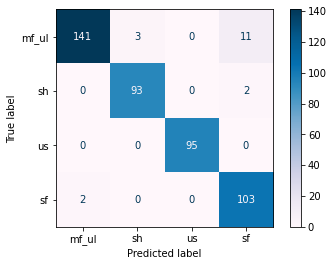

In [12]:
# accuracy of first classification step on training data

training_classes_first = gpd.read_file(training_classes_in)
training_classes_first.FID = training_classes_first.FID.astype(np.int64)
training_classes_first.loc[(training_classes_first.class_name == 'mf') |
                           (training_classes_first.class_name == 'ul'),
                           'class_name'] = 'mf_ul'
if not 'data_classified_full' in globals():
    data_classified_full = gpd.read_file(outfile_classified)
    data_classified_full.FID = data_classified_full.FID.astype(np.int64)

data_classified_first = data_classified_full.copy()
data_classified_first.FID = data_classified_full.FID.astype(np.int64)
data_classified_first.loc[(data_classified_first.class_name == 'mf') |
                          (data_classified_first.class_name == 'ul'),
                          'class_name'] = 'mf_ul'

pred = data_classified_first[
    data_classified_first.FID.isin(training_classes_first.FID)]

# training_classes_first = training_classes_first[training_classes_first.FID.isin(pred.FID)]
# pred = training_classes_first.drop(columns='class_name').merge(data_classified_full[['class_name', 'FID']], on='FID')

labels = list(set(pred.class_name))
confusion_matrix = metrics.confusion_matrix(training_classes_first.class_name, 
                                            pred.class_name, 
                                            normalize=None,
                                            labels=labels)
print("Accuracy assessment of the first step on training data")
metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=labels).plot(cmap='PuBu')

confusion_matrix


Accuracy assessment of the 2nd step on training data


array([[80,  1,  6,  8],
       [ 0,  0,  0,  0],
       [ 7,  2, 48,  3],
       [ 0,  0,  0,  0]])

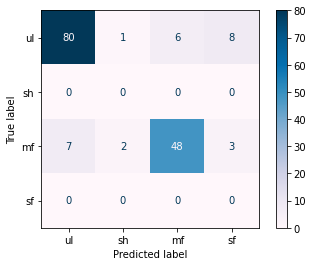

In [13]:
# accuracy of 2nd classification step on training data

training_classes_mful = gpd.read_file(training_classes_in)
training_classes_mful.FID = training_classes_mful.FID.astype(np.int64)
training_classes_mful = training_classes_mful[(training_classes_mful.class_name == 'mf') |
                                              (training_classes_mful.class_name == 'ul')]

if not 'data_classified_full' in globals():
    data_classified_full = gpd.read_file(outfile_classified)
    data_classified_full.FID = data_classified_full.FID.astype(np.int64)

pred = data_classified_full[data_classified_full.FID.isin(training_classes_mful.FID)]

# training_classes_mful = training_classes_mful[training_classes_mful.FID.isin(pred.FID)]
# pred = training_classes_mful.drop(columns='class_name').merge(data_classified_full[['class_name', 'FID']], on='FID')

labels = list(set(pred.class_name))
confusion_matrix = metrics.confusion_matrix(training_classes_mful.class_name, 
                                            pred.class_name, 
                                            normalize=None,
                                            labels=labels)
print("Accuracy assessment of the 2nd step on training data")
metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=labels).plot(cmap='PuBu')
confusion_matrix

Accuracy assessment for the fully classified dataset on reference data


array([[54,  1,  0,  1,  4],
       [ 0, 52,  0,  1,  7],
       [ 0,  0, 60,  0,  0],
       [ 0,  0,  0, 60,  0],
       [ 0, 12,  0,  1, 47]])

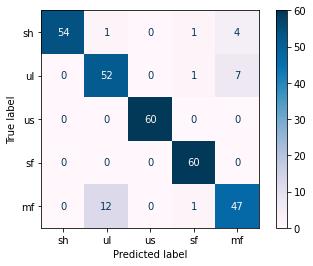

In [14]:
# accuracy test on reference data

ref = gpd.read_file(reference_classes)

ref.FID = ref.FID.astype(np.int64)
if not 'data_classified_full' in globals():
    data_classified_full = gpd.read_file(outfile_classified)
    data_classified_full.FID = data_classified_full.FID.astype(np.int64)

pred = data_classified_full[data_classified_full.FID.isin(ref.FID)]

# ref = ref[ref.FID.isin(data_classified_full.FID)]
# pred = ref.drop(columns='class_name').merge(data_classified_full[['class_name', 'FID']], on='FID')

labels = list(set(pred.class_name))
confusion_matrix = metrics.confusion_matrix(ref.class_name, 
                                            pred.class_name, 
                                            normalize=None, 
                                            labels=labels)
print("Accuracy assessment for the fully classified dataset on reference data")
metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=labels).plot(cmap='PuBu')
confusion_matrix

<a name="statistics"></a>
# Statistics

<a name="feature_count"></a>
## Feature counts

In [15]:
def statistics(filename):
    if type(filename) == str:
        gdf = gpd.read_file(filename)
        print("\nStatistics for", str(filename))
    else:
        gdf = filename
        print("\nStatistics for", set(data_mful.class_name))
    us = gdf[gdf.class_name == 'us'].shape[0]
    sh = gdf[gdf.class_name == 'sh'].shape[0]
    sf = gdf[gdf.class_name == 'sf'].shape[0]
    mf = gdf[gdf.class_name == 'mf'].shape[0]
    ul = gdf[gdf.class_name == 'ul'].shape[0]
    len(data[data.area <= 25])
    print('us =', us,
          '\nsh =', sh,
          '\nsf =', sf,
          '\nmf =', mf,
          '\nul =', ul,
          '\n------------',
          '\nsum =', len(data))


statistics(training_classes_in)

statistics(reference_classes)

statistics(outfile_classified)

statistics(data_mful)


Statistics for ./Input/Hue_training_classes_no_params.csv
us = 95 
sh = 95 
sf = 105 
mf = 60 
ul = 95 
------------ 
sum = 108749

Statistics for ./Input/Hue_reference_classes_preprocessed.csv
us = 60 
sh = 60 
sf = 60 
mf = 60 
ul = 60 
------------ 
sum = 108749

Statistics for ./Output/Daten/Hue_buildings_UTM48N_classified_full.shp
us = 30501 
sh = 19343 
sf = 53820 
mf = 3143 
ul = 1942 
------------ 
sum = 108749

Statistics for {'ul', 'mf'}
us = 0 
sh = 0 
sf = 0 
mf = 3143 
ul = 1942 
------------ 
sum = 108749


<a name="wards"></a>
## Ward related statistics
The file `./Output/Statistik/Hue_wards_w_stats.csv` is created here. Under use of a GADM-provided file containing the adminstrative boundaries of Vietnam, the count of each class per ward of Hue is extracted. 

In [16]:
# Adding wards based statistics
# Counting building types in wards

wards = reproject(gpd.read_file('./Input/gadm36_VNM_3.shp'))
wards_hue = gpd.GeoDataFrame(wards[wards.NAME_2 == 'Huế'])
if not 'data_classified_full' in globals():
    data_classified_full = gpd.read_file(outfile_classified)
    data_classified_full.FID = data_classified_full.FID.astype(np.int64)

for i, row in tqdm(wards_hue.iterrows(), total=wards_hue.shape[0]):
    for class_name in ['sh', 'sf', 'mf', 'ul', 'us']:
        wards_hue.loc[i, 'n_'+class_name] = data_classified_full[
            data_classified_full.class_name == class_name
            ].centroid.sindex.query(
                row.geometry, predicate='intersects'
                ).shape[0]

wards_hue.to_csv('./Output/Statistik/Hue_wards_w_stats.csv')

Reprojecting to EPSG 32648


100%|██████████| 27/27 [00:14<00:00,  1.88it/s]


<a name="boxplots"></a>
## Boxplots and histograms
Boxplots and histograms for all the features are being generated here and written to `./Output/Statistik/`.

In [6]:
if not os.path.exists('./Output/Statistik'):
    os.mkdir('./Output/Statistik')

width = 14
height = 12
#### Statistiks for the parameters of the first step ####

ref = gpd.read_file('./Input/Hue_reference_classes_preprocessed.csv')
ref.FID = ref.FID.astype(np.int64)

if not 'data_classified_full' in globals():
    data_classified_full = gpd.read_file(outfile_classified)
    data_classified_full.FID = data_classified_full.FID.astype(np.int64)

pred = data_classified_full# data_classified_full[data_classified_full.FID.isin(ref.FID)]
ref_w_params = pred.copy()

for colname in list(pred.columns):
    if colname not in [ 'geometry', 'FID', 'bID', 'class_name',
                        'nearest', 'class_50', 'b_class', 
                        'b_mful_rat', 'mful_50']: 
        (
            ggplot(pred)
            + geom_boxplot(
                aes(x='class_name', 
                    y=colname),
                colour="#1F3552",
                fill="#4271AE",
                alpha=0.7,
                outlier_shape=".",
                outlier_colour="steelblue",
                width=0.5
                )
            #+ scale_x_discrete(labels=list(set(pred.class_name)), name='class') 
            + ggtitle(colname)
            + theme_bw()
        ).save("./Output/Statistik/boxplot_{name}.svg".format(name=colname), units='cm', width=width, height=height)

#### Statistiks for the parameters of the first step trimmed ####

if not os.path.exists('./Output/Statistik'):
    os.mkdir('./Output/Statistik')

ref = gpd.read_file('./Input/Hue_reference_classes_preprocessed.csv')
ref.FID = ref.FID.astype(np.int64)

if not 'data_classified_full' in globals():
    data_classified_full = gpd.read_file(outfile_classified)
    data_classified_full.FID = data_classified_full.FID.astype(np.int64)

pred = data_classified_full# data_classified_full[data_classified_full.FID.isin(ref.FID)]
ref_w_params = pred.copy()

# format: [param_name, max_value]
for i in [
          ['area', 1000], 
          ['area_mabr', 1000],
          ['b_msize', 500], 
          ['msize_50', 500], 
          ['perimeter', 200],
          ['tess_area', 4000]
         ]:
    (
        ggplot(pred)
        + geom_boxplot(
            aes(x='class_name', 
                y=i[0]),
                colour="#1F3552",
                fill="#4271AE",
                alpha=0.7,
                outlier_shape=".",
                outlier_colour="steelblue",
                width=0.5
                )
        #+ scale_x_discrete(labels=list(set(pred.class_name)), name='class') 
        + ggtitle(i[0])
        + theme_bw()
        + ylim(0, i[1])
        + xlab("{title}\n\nNote: Outliers above {limit}\nhave been omitted in the figure".format(title='class_name', limit=i[1]))
    ).save("./Output/Statistik/cut_boxplot_{name}.svg".format(name=i[0]), units='cm', width=width, height=height)
        
        
#### Statistiks for the parameters of the second step ####

ref_2_w_params = pred[(pred.class_name == 'mf') | (pred.class_name == 'ul')].copy() 

for colname in ['nearest', 'class_50', 'b_class']:
    for mful in ['mf', 'ul']:
        (
            ggplot(ref_2_w_params[ref_2_w_params.class_name == mful])
            + geom_histogram(aes(x=colname), 
                                binwidth=0.5,
                                colour="#1F3552",
                                fill="#4271AE",
                                alpha=0.7,
                                na_rm=True)
            + ggtitle(mful+": "+colname)
            + theme_bw()
        ).save("./Output/Statistik/histogram_step2_{mful}_{name}.svg".format(mful=mful, 
                                                                    name=colname), units='cm', width=width, height=height)

#ggplot(ref_2_w_params) + geom_boxplot(aes(x='class_name', y='b_mful_rat'))
#ggplot(ref_2_w_params) + geom_boxplot(aes(x='class_name', y='mful_50m'))

/home/user/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 14.0 x 12.0 cm image.
/home/user/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./Output/Statistik/boxplot_area.svg
/home/user/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 14.0 x 12.0 cm image.
/home/user/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./Output/Statistik/boxplot_corners.svg
/home/user/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 14.0 x 12.0 cm image.
/home/user/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./Output/Statistik/boxplot_perimeter.svg
/home/user/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 14.0 x 12.0 cm image.
/home/user/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: 

<a name="resi"></a>
## Residential housings
Statistical evaluation of housings per floor area

In [15]:
## Distribution of residential housholds by area in Hue

residential = data_classified_full[data_classified_full.class_name.isin(['mf', 'sh', 'sf'])]
if not 'data_classified_full' in globals():
    data_classified_full = gpd.read_file(outfile_classified)
    data_classified_full.FID = data_classified_full.FID.astype(np.int64)

def housings(data, start, stop):
    
    total = data[(data.area >= start) & (data.area <= stop)].shape[0]
    perc = total / data.shape[0]
    print("{start}m² - {stop}m²: {total} ({perc}%)".format(
        start=start,
        stop=stop,
        total=total,
        perc=np.round(perc*100, 1)))

for i in [[0, 14], [15, 24], [25, 36], [37, 48], [49, 59], [60, np.inf]]:
    housings(residential, i[0], i[1])    
          


0m² - 14m²: 0 (0.0%)
15m² - 24m²: 0 (0.0%)
25m² - 36m²: 12195 (16.0%)
37m² - 48m²: 20381 (26.7%)
49m² - 59m²: 13274 (17.4%)
60m² - infm²: 25827 (33.8%)


<a name="means"></a>
## Means and standard deviation

The parameter's mean values and standard deviations for each class area calculated here

In [76]:
## Calculation of parameters' mean values and standard deviation per class
if not 'data_classified_full' in globals():
    data_classified_full = gpd.read_file(outfile_classified)
    data_classified_full.FID = data_classified_full.FID.astype(np.int64)

for i in data_classified_full.columns:
    if type(data_classified_full[data_classified_full.class_name == j][i].values[1]) == np.float64:
        for j in set(data_classified_full.class_name):
            print('\n'+i, j)
            print("  Mean:", np.mean(data_classified_full[data_classified_full.class_name == j][i].values))
            print("  Std.:", np.std(data_classified_full[data_classified_full.class_name == j][i].values))
        else:
            pass
        print('__________________________\n')   


area sh
  Mean: 58.405346106084885
  Std.: 23.18682141160673

area sf
  Mean: 54.07417577127462
  Std.: 20.795062780604844

area mf
  Mean: 185.84780893095768
  Std.: 96.77600374398948

area ul
  Mean: 381.8490201390319
  Std.: 370.86931409426586

area us
  Mean: 20.96882325727025
  Std.: 6.096562853277103
__________________________


perimeter sh
  Mean: 34.1842715287184
  Std.: 7.422355122624564

perimeter sf
  Mean: 29.576261463396506
  Std.: 5.546189091684427

perimeter mf
  Mean: 60.11464432071269
  Std.: 16.46957650617178

perimeter ul
  Mean: 87.24896680226571
  Std.: 45.534099969119964

perimeter us
  Mean: 19.01601088357759
  Std.: 3.209996508264248
__________________________


rect sh
  Mean: 0.9867678002378121
  Std.: 0.04016467825613592

rect sf
  Mean: 0.9840023875882571
  Std.: 0.05177118274784027

rect mf
  Mean: 0.91324691695832
  Std.: 0.12693205431592927

rect ul
  Mean: 0.9248803759011329
  Std.: 0.1377828930607808

rect us
  Mean: 0.9870653742500246
  Std.: 0.04400